In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pickle
from google.colab import drive
import cv2


drive.mount('/content/drive')


data_path = "/content/drive/MyDrive/data/car_racing_rollouts_5.pkl"
with open(data_path, "rb") as f:
    rollouts = pickle.load(f)
print("success!")




Mounted at /content/drive


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/data/car_racing_rollouts_5.pkl'

In [ ]:

states = []
rewards = []
for episode in rollouts:
    for transition in episode:
        obs, action, reward, next_obs, done = transition
        states.append(obs)
        rewards.append(reward)
states = np.array(states)  # shape: (N, 64, 64)
states = states[:, np.newaxis, :, :]  # channel dim: (N, 1, 64, 64)
rewards = np.array(rewards)  # shape: (N,)
print("Total states:", states.shape[0])


class CarRacingDataset(Dataset):
    def __init__(self, states, rewards):
        self.states = torch.tensor(states, dtype=torch.float32)
    def __len__(self):
        return self.states.shape[0]
    def __getitem__(self, idx):
        return self.states[idx]

dataset = CarRacingDataset(states, rewards)
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

latent_dim = 64

In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        # (input: [1, 64, 64])
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),   # -> [32, 32, 32]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),    # -> [64, 16, 16]
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),   # -> [128, 8, 8]
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # -> [256, 4, 4]
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(256 * 4 * 4, latent_dim)


        self.reward_head = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )


        self.fc_decode = nn.Linear(latent_dim, 256 * 4 * 4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), # -> [128, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # -> [64, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # -> [32, 32, 32]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),    # -> [1, 64, 64]
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # standard deviation
        eps = torch.randn_like(std)    # sample from N(0,1)
        return mu + std * eps          # z = mu + sigma * epsilon

    def decode(self, z):
        x = self.fc_decode(z)
        x = x.view(-1, 256, 4, 4)
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        reward_pred = self.reward_head(z)
        return x_recon, mu, logvar, reward_pred

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


bce = 0
kld = 0
reward = 0
# Loss function combining reconstruction, KL divergence, and reward prediction using uncertainty weighting
def loss_function(recon_x, x, mu, logvar, reward_pred, reward, model):
    # Compute individual losses
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    reward_loss = nn.functional.mse_loss(reward_pred.squeeze(), reward, reduction='sum')

    reward += reward_loss
    bce += BCE
    kld += KLD
    # Final combined loss
    total_loss = BCE + (50*reward_loss) + KLD
    return total_loss




# Training loop
epochs = 50
model.train()
for epoch in range(1, epochs + 1):
    train_loss = 0
    total_bce = 0
    total_reward_loss = 0
    total_kld = 0
    for batch in dataloader:
        img, reward = batch
        img = img.to(device)
        reward = reward.to(device)  # reward shape: [batch_size] or [batch_size, 1]

        optimizer.zero_grad()
        recon_batch, mu, logvar, reward_pred = model(img)
        loss = loss_function(recon_batch, img, mu, logvar, reward_pred, reward, model)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()




    avg_loss = train_loss / len(dataset)
    print(f"Epoch {epoch}, Average Loss: {avg_loss:.4f}")
    avg_reward_losss =  reward/len(dataset)
    avg_bce_loss =  bce/len(dataset)
    avg_kld_loss =  kld/len(dataset)
    print(f"Epoch {epoch}, Average reward Loss: {avg_reward_losss:.4f}")
    print(f"Epoch {epoch}, Average bce Loss: {avg_bce_loss:.4f}")
    print(f"Epoch {epoch}, Average kld Loss: {avg_kld_loss:.4f}")
    bce = 0
    kld = 0
    reward = 0

# Save the trained model to Google Drive
torch.save(model.state_dict(), "/content/drive/MyDrive/vae_car_racing_newloss3.pth")
print("Model saved!")

NameError: name 'latent_dim' is not defined

In [ ]:
import matplotlib.pyplot as plt

# Switch model to evaluation mode
model.eval()
with torch.no_grad():
    sample, _ = next(iter(dataloader))  # Unpack image and reward
    sample = sample.to(device)  # Move only the image to the device
    recon, _, _,_= model(sample)  # Forward pass


sample = sample.cpu().numpy()
recon = recon.cpu().numpy()

# Ploting first 5 original and reconstructed images
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    axs[0, i].imshow(sample[i].squeeze(), cmap='gray')
    axs[0, i].set_title("Original")
    axs[0, i].axis('off')

    axs[1, i].imshow(recon[i].squeeze(), cmap='gray')
    axs[1, i].set_title("Reconstruction")
    axs[1, i].axis('off')

plt.show()


In [ ]:
# # Training loop with detailed loss logging
# epochs = 50
# model.train()
# for epoch in range(1, epochs + 1):
#     train_loss = 0
#     total_bce = 0
#     total_reward_loss = 0
#     total_kld = 0

#     for batch in dataloader:
#         img, reward = batch
#         img = img.to(device)
#         reward = reward.to(device)

#         optimizer.zero_grad()
#         recon_batch, mu, logvar, reward_pred = model(img)

#         # Calculate individual losses
#         BCE = nn.functional.binary_cross_entropy(recon_batch, img, reduction='sum')
#         KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#         reward_loss = nn.functional.mse_loss(reward_pred.squeeze(), reward, reduction='sum')

#         # Scaling and hyperparameters
#         scaling_factor = 2000  # As determined from your averages
#         scaled_reward_loss = reward_loss * scaling_factor
#         lambda_val = 0.5
#         beta_val = 20

#         # Total loss
#         loss = BCE + lambda_val * scaled_reward_loss + beta_val * KLD
#         loss.backward()
#         optimizer.step()

#         train_loss += loss.item()
#         total_bce += BCE.item()
#         total_reward_loss += reward_loss.item()
#         total_kld += KLD.item()

#     avg_loss = train_loss / len(dataset)
#     avg_bce = total_bce / len(dataset)
#     avg_reward_loss = total_reward_loss / len(dataset)
#     avg_kld = total_kld / len(dataset)

#     print(f"Epoch {epoch}, Total Loss: {avg_loss:.4f}, BCE: {avg_bce:.4f}, "
#           f"Reward Loss: {avg_reward_loss:.4f}, KLD: {avg_kld:.4f}")


Epoch 1, Total Loss: 4412.5582, BCE: 2372.4877, Reward Loss: 1.8426, KLD: 9.8760
Epoch 2, Total Loss: 4505.1474, BCE: 2377.4627, Reward Loss: 1.9646, KLD: 8.1562
Epoch 3, Total Loss: 3586.5608, BCE: 2373.6318, Reward Loss: 1.0884, KLD: 6.2248
Epoch 4, Total Loss: 3421.9883, BCE: 2372.9875, Reward Loss: 0.9395, KLD: 5.4765
Epoch 5, Total Loss: 3374.1000, BCE: 2372.2060, Reward Loss: 0.8938, KLD: 5.4057
Epoch 6, Total Loss: 3383.8922, BCE: 2373.0668, Reward Loss: 0.9085, KLD: 5.1178
Epoch 7, Total Loss: 3256.3790, BCE: 2372.3756, Reward Loss: 0.7872, KLD: 4.8388
Epoch 8, Total Loss: 3632.4677, BCE: 2372.9483, Reward Loss: 1.1548, KLD: 5.2341
Epoch 9, Total Loss: 3267.2516, BCE: 2373.2087, Reward Loss: 0.7969, KLD: 4.8563
Epoch 10, Total Loss: 3224.2379, BCE: 2372.1911, Reward Loss: 0.7602, KLD: 4.5938
Epoch 11, Total Loss: 3246.3737, BCE: 2372.1186, Reward Loss: 0.7774, KLD: 4.8435
Epoch 12, Total Loss: 3336.2125, BCE: 2372.3708, Reward Loss: 0.8765, KLD: 4.3670
Epoch 13, Total Loss: 317

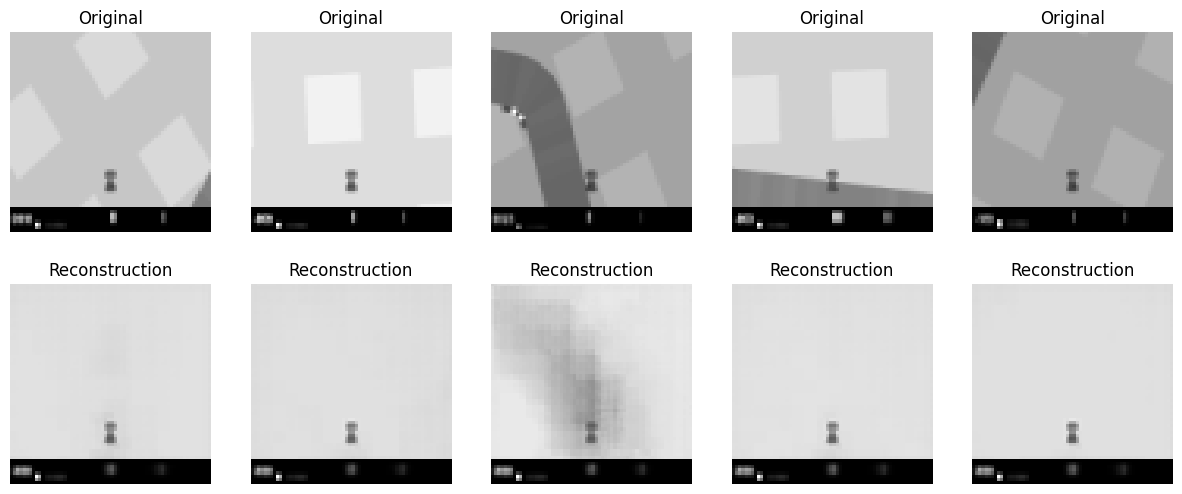

In [ ]:
import matplotlib.pyplot as plt



model.eval()
with torch.no_grad():
    sample, _ = next(iter(dataloader))
    sample = sample.to(device)
    recon, _, _,_= model(sample)


sample = sample.cpu().numpy()
recon = recon.cpu().numpy()


fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    axs[0, i].imshow(sample[i].squeeze(), cmap='gray')
    axs[0, i].set_title("Original")
    axs[0, i].axis('off')

    axs[1, i].imshow(recon[i].squeeze(), cmap='gray')
    axs[1, i].set_title("Reconstruction")
    axs[1, i].axis('off')

plt.show()


In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/vae_car_racing_newloss1.pth")
print("Model saved!")